In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Imports

In [7]:
# file imports
file_path_forecasts = '../data/raw/ibes-forecasts.parquet'

# IBES forecasts
df_forecasts = pd.read_parquet(file_path_forecasts)
df_forecasts.head()

,TICKER,CUSIP,OFTIC,CNAME,ESTIMATOR,ANALYS,FPI,MEASURE,VALUE,FPEDATS,REVDATS,ANNDATS,ACTUAL,ANNDATS_ACT
0,0000,87482X10,TLMR,TALMER BANCORP,149,119962,1,EPS,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30
1,0000,87482X10,TLMR,TALMER BANCORP,228,80474,1,EPS,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
2,0000,87482X10,TLMR,TALMER BANCORP,952,50789,1,EPS,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
3,0000,87482X10,TLMR,TALMER BANCORP,873,79092,1,EPS,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30
4,0000,87482X10,TLMR,TALMER BANCORP,1267,71182,1,EPS,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30


In [4]:
df_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620437 entries, 0 to 2620436
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   TICKER       object 
 1   CUSIP        object 
 2   OFTIC        object 
 3   CNAME        object 
 4   ESTIMATOR    int64  
 5   ANALYS       int64  
 6   FPI          int64  
 7   MEASURE      object 
 8   VALUE        float64
 9   FPEDATS      object 
 10  REVDATS      object 
 11  ANNDATS      object 
 12  ACTUAL       float64
 13  ANNDATS_ACT  object 
dtypes: float64(2), int64(3), object(9)
memory usage: 279.9+ MB


# Preprocessing
df_forecasts:
- Lower case all columns in df_forecasts
- Drop unncessary columns
- Include only forecasts issued no earlier than 1 year ahead and no later than 30 days before fiscal year end
- Rename columns
- Delete rows with actual_eps = NAN or estimated_eps = NAN
- Exclude forecasts for companies which only one analyst provides a forecast
- Exclude all analysts appearing in the initial 2-3 years of the dataset (migitating problem of experience)
- (Retain the last forecast an analyst issues in a particular year)
- ...

In [5]:
# lower case
df_forecasts = df_forecasts.rename(columns={col: col.lower() for col in df_forecasts.columns})

# Drop unncessary columns
columns_to_drop = ["fpi","measure","cusip"]
df_forecasts = df_forecasts.drop(columns=columns_to_drop)

In [6]:
# convert columns with dates to datetime
def convert_to_datetime(df):
    columns_to_convert = ['fpedats','revdats', "anndats", 'anndats_act']
    for column in columns_to_convert:
        df[column] = pd.to_datetime(df[column])
    return df
df_forecasts = convert_to_datetime(df_forecasts)

# filter forecasts  based on time
df_forecasts['forecast_horizon'] = df_forecasts['fpedats'] - df_forecasts['anndats']
df_forecasts = df_forecasts[(df_forecasts['forecast_horizon']> pd.Timedelta(days=30))&(df_forecasts['forecast_horizon']<pd.Timedelta(days=365))]

# calculate the mean forecast horizon of analyst i's forecasts for company j in fiscal period t and append to df
df_forecasts['mean_forecast_horizon_days'] = df_forecasts.groupby(['analys','ticker','fpedats'])['forecast_horizon'].transform('mean')
df_forecasts['mean_forecast_horizon_days'] = df_forecasts['mean_forecast_horizon_days'].dt.days
df_forecasts.head()

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182


restrict time horizon

In [ ]:
# show first and last date entry rows
print(df_forecasts['fpedats'].min())
print(df_forecasts['fpedats'].max())

2010-02-28 00:00:00
2024-07-31 00:00:00


In [8]:
print(df_forecasts['anndats'].min())
print(df_forecasts['anndats'].max())

2010-01-03 00:00:00
2023-09-14 00:00:00


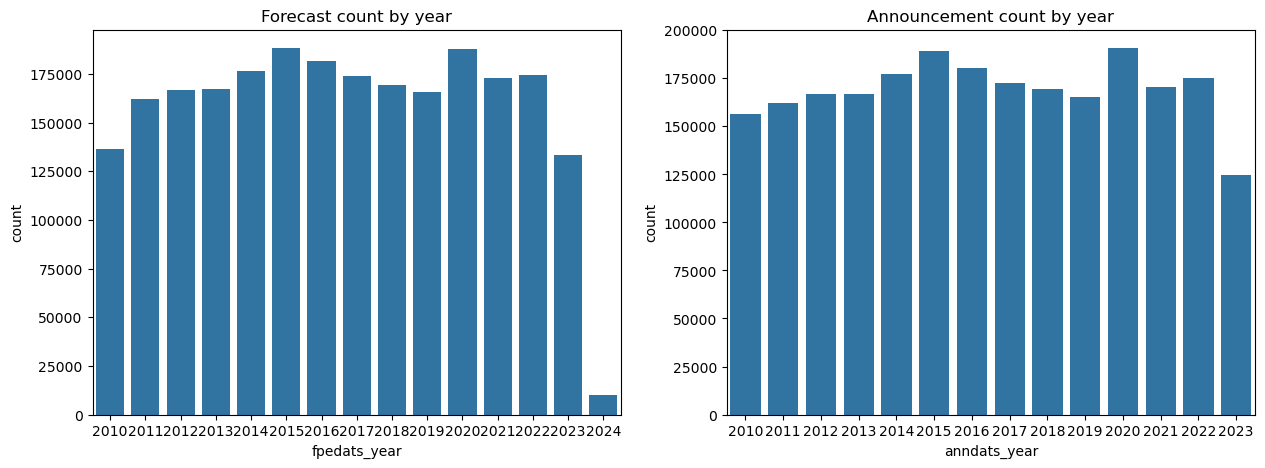

In [9]:
# plot the forecast count by year over time for the entire dataset
df_forecasts['fpedats_year'] = df_forecasts['fpedats'].dt.year
df_forecasts['anndats_year'] = df_forecasts['anndats'].dt.year

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=df_forecasts, x='fpedats_year', ax=ax[0])
ax[0].set_title('Forecast count by year')
sns.countplot(data=df_forecasts, x='anndats_year', ax=ax[1])
ax[1].set_title('Announcement count by year')
plt.show()

In [10]:
# test
analyst_id = 113333
subset_analyst_i = df_forecasts[(df_forecasts['ticker'] == "AAPL") & (df_forecasts['fpedats'].dt.year == 2020) & (df_forecasts['analys'] == analyst_id)]
subset_analyst_i

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year
128641,AAPL,AAPL,APPLE,171,113333,3.2565,2020-09-30,2020-01-22,2019-10-30,3.28,2020-10-29,336 days,291,2020,2019
128696,AAPL,AAPL,APPLE,171,113333,3.3510,2020-09-30,2020-01-28,2020-01-28,3.28,2020-10-29,246 days,291,2020,2020


rename columns to natural language

In [11]:
# rename columns
df_forecasts = df_forecasts.rename(columns={"ticker": "ibes_ticker_pk", "oftic": "official_ticker", "cname": "company_name",
                                            "analys": "analyst", "value": "estimated_eps", "fpedats": "fiscal_period_ending", 
                                            "revdats": "revision_date", "anndats": "announce_date", "actual": "actual_eps", "anndats_act": "announce_date_actual",
                                            "difference_date": "forecast_horizon"})

In [12]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,2014,2014
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,2014,2014
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,2014,2014
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,2014,2014
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,2014,2014


remove empty rows:

In [13]:
# drop all rows where the actual_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['actual_eps'])

Number of rows dropped:  180990


In [14]:
# drop all rows where the estimated_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['estimated_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['estimated_eps'])

Number of rows dropped:  145


# Accuracies

## Variant 1: PMAFE 
PMAFE is the proportional mean absolute forecast error

$$PMAFE = \frac{DAFE_{ijt}}{\overline{AFE_{jt}}} = \frac{AFE_{ijt} - \overline{AFE_{jt}}}{\overline{AFE_{jt}}} $$

where 
- $AFE_{ijt}$ is the absolute forecast error for analyst i's forecast of firm j for year t, and 
- $\overline{AFE_{jt}}$ is the mean absolute forecast error for firm j for year t

Negative PMAFE: better than average performance of analyst i (capped at -1.0)

Postive PMAFE: worse than average performance (theoretically towards infinity)

Source: Analyst forecast accuracy:
Do ability, resources, and
portfolio complexity matter?q
Michael B. Clement

In [15]:
def calculate_pmafe(df):
    """
    This function first calculates the absolute forecast error for each analyst i forecast of firm j in year t
    If analyst i has multiple forecasts for firm j in year t, the function calculates the average forecast error
    In the second step an extra column is calculated for the overall forecast error is calculate for each firm j in year t
    In the third step, the function calculates the PMAFE for each analyst i forecast of firm j in year t
    This function adds new columns to the dataframe:
    - afe_analyst_i: the absolute forecast error for each analyst i forecast of firm j in year t
    - afe_analyst_ijt_mean: the average absolute forecast error for each analyst i forecast of firm j in year t
    - afe_firm_jt_mean: the overall forecast error for each firm j in year t
    - pmafe: the PMAFE for each analyst i forecast of firm j in year t
    """
    # Step 1: Calculate the average absolute forecast error for each analyst i forecast of firm j in year t
    df['afe_analyst_i'] = np.abs(df['estimated_eps'] - df['actual_eps'])
    
    df_grouped = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending']).agg({'afe_analyst_i': 'mean'}).reset_index()
    df_grouped = df_grouped.rename(columns={'afe_analyst_i': 'afe_analyst_ijt_mean'})
    df = pd.merge(df, df_grouped, on=['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'], how='left')
    
    # Step 2: Calculate the overall forecast error for each firm j in year t
    df['afe_firm_jt_mean'] = df.groupby(["ibes_ticker_pk", "fiscal_period_ending"])["afe_analyst_i"].transform("mean")
    
    # Step 3: Calculate the PMAFE for each analyst i forecast of firm j in year t
    df['pmafe'] = (df['afe_analyst_ijt_mean'] - df['afe_firm_jt_mean']) / df['afe_firm_jt_mean']
    
    return df

In [16]:
df_forecasts = calculate_pmafe(df_forecasts)
df_forecasts.head()

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe
0,0000,TLMR,TALMER BANCORP,149,119962,0.73,2014-12-31,2014-03-11,2014-03-09,1.21,2015-01-30,297 days,200,2014,2014,0.48,0.376000,0.3575,0.051748
1,0000,TLMR,TALMER BANCORP,228,80474,0.83,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,214,2014,2014,0.38,0.367143,0.3575,0.026973
2,0000,TLMR,TALMER BANCORP,952,50789,0.66,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,182,2014,2014,0.55,0.404000,0.3575,0.130070
3,0000,TLMR,TALMER BANCORP,873,79092,0.80,2014-12-31,2014-03-11,2014-03-10,1.21,2015-01-30,296 days,187,2014,2014,0.41,0.424286,0.3575,0.186813
4,0000,TLMR,TALMER BANCORP,1267,71182,0.86,2014-12-31,2014-04-07,2014-03-17,1.21,2015-01-30,289 days,182,2014,2014,0.35,0.142500,0.3575,-0.601399


### Descriptive Analysis PMAFE

In [17]:
# show me all rows where pmafe is NaN and print the count
print("Number of rows with pmafe NaN: ", df_forecasts['pmafe'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['pmafe'])

Number of rows with pmafe NaN:  102


Exclude forecasts for companies in year t, if only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated) AND the analyst provides a perfect forecast

In [18]:
# Exclude forecasts for companies in year t for which only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated)
print(df_forecasts.shape[0])

df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts = df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

print(df_forecasts.shape[0])


2185798
2137411


In [19]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -0.9999847530470667
The highest PMAFE is:  67.00421113621117


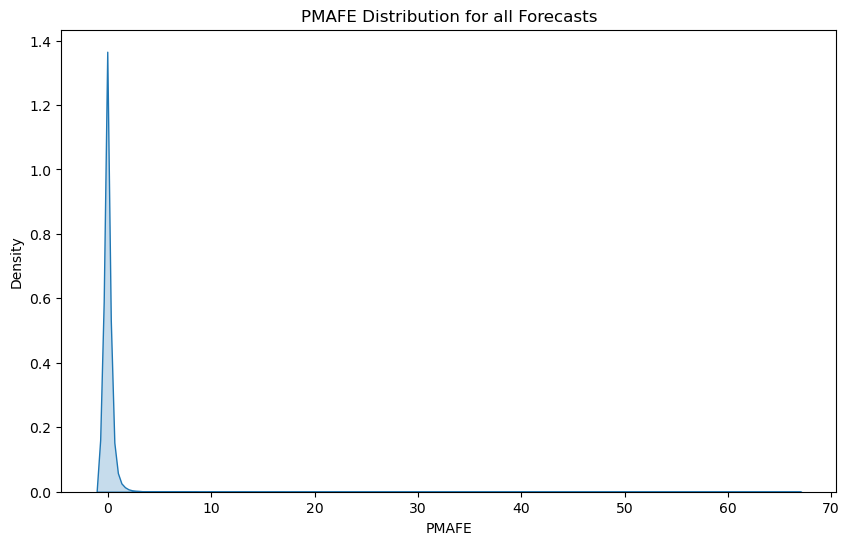

In [ ]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

# Feature Engineering
## From RAW df

### Feature: Broker Size

## From collapsed df

### Collapse df

in the final df, one row should correspond to one analyst i's mean forecast of firm j in fiscal year t with accuracy measure pmafe

columns:
 - ibes_ticker_pk
 - company_name
 - gvkey
 - fiscal_period_ending
 - analyst
 - estimator
 - estimated_eps
 - mean_forecast_horizon
 - actual_eps
 - announce_date_actual
 - pmafe
 - afe_analyst_i_mean
 - afe_firm_j_mean
 - feature x
 - ...

### Feature : Coverage

In [ ]:
df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

ibes_ticker_pk official_ticker    company_name  estimator  analyst  \
0                 0000            TLMR  TALMER BANCORP        149   119962   
1                 0000            TLMR  TALMER BANCORP        228    80474   
2                 0000            TLMR  TALMER BANCORP        952    50789   
3                 0000            TLMR  TALMER BANCORP        873    79092   
4                 0000            TLMR  TALMER BANCORP       1267    71182   
...                ...             ...             ...        ...      ...   
2185791           ZYNX            ZYXI       ZYNEX INC       2709   122730   
2185792           ZYNX            ZYXI       ZYNEX INC       1549   191964   
2185793           ZYNX            ZYXI       ZYNEX INC       2709   122730   
2185794           ZYNX            ZYXI       ZYNEX INC        926   118308   
2185795           ZYNX            ZYXI           ZYNEX        220   193620   

         estimated_eps fiscal_period_ending revision_date announce_date  \
0                0.730           2014-12-31    2014-03-11    2014-03-09   
1                0.830           2014-12-31    2014-03-11    2014-03-10   
2                0.660           2014-12-31    2014-03-11    2014-03-10   
3                0.800           2014-12-31    2014-03-11    2014-03-10   
4                0.860           2014-12-31    2014-04-07    2014-03-17   
...                ...                  ...           ...           ...   
2185791          0.480           2022-12-31    2022-05-02    2022-04-29   
2185792          0.420           2022-12-31    2022-10-19    2022-07-15   
2185793          0.460           2022-12-31    2022-07-29    2022-07-29   
2185794          0.420           2022-12-31    2023-01-18    2022-07-29   
2185795          0.423           2022-12-31    2023-01-06    2022-10-27   

         actual_eps announce_date_actual forecast_horizon  \
0              1.21           2015-01-30         297 days   
1              1.21           2015-01-30         296 days   
2              1.21           2015-01-30         296 days   
3              1.21           2015-01-30         296 days   
4              1.21           2015-01-30         289 days   
...             ...                  ...              ...   
2185791        0.44           2023-03-13         246 days   
2185792        0.44           2023-03-13         169 days   
2185793        0.44           2023-03-13         155 days   
2185794        0.44           2023-03-13         155 days   
2185795        0.44           2023-03-13          65 days   

         mean_forecast_horizon_days  afe_analyst_i  afe_analyst_ijt_mean  \
0                               200          0.480              0.376000   
1                               214          0.380              0.367143   
2                               182          0.550              0.404000   
3                               187          0.410              0.424286   
4                               182          0.350              0.142500   
...                             ...            ...                   ...   
2185791                         207          0.040              0.054000   
2185792                         197          0.020              0.007500   
2185793                         207          0.020              0.054000   
2185794                         236          0.020              0.033333   
2185795                         156          0.017              0.023500   

         afe_firm_jt_mean     pmafe  analyst_count  
0                0.357500  0.051748             28  
1                0.357500  0.026973             28  
2                0.357500  0.130070             28  
3                0.357500  0.186813             28  
4                0.357500 -0.601399             28  
...                   ...       ...            ...  
2185791          0.035867  0.505576             15  
2185792          0.035867 -0.790892             15  
2185793          0.035867  0.505576            

In [ ]:
# Exclude forecasts for companies in year t for which only one analyst provides a forecast (otherwise pmafe = NaN if actual == estimated)
print(df_forecasts.shape[0])
df_forecasts['analyst_count'] = df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

df_forecasts = df_forecasts[(df_forecasts['analyst_count'] > 1) & (df_forecasts["afe_analyst_i"] != 0)]

print(df_forecasts.shape[0])


2185943
2137558


In [ ]:
df_forecasts

NameError: name 'df_forecasts' is not defined

In [57]:
df_forecasts.groupby(['ibes_ticker_pk','fiscal_period_ending'])['analyst'].transform('count')

0          27
1          27
2          27
3          27
4          27
           ..
2185936    12
2185937    12
2185938    12
2185939    12
2185940    12
Name: analyst, Length: 2137438, dtype: int64

In [ ]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -0.9999847530470667
The highest PMAFE is:  67.00421113621117


In [ ]:
df_forecasts[df_forecasts['pmafe']>60]

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.66,2018-12-31,2018-11-01,2018-10-31,66.31,2019-02-21,61 days,61,677.35,677.35,9.960413,67.004211,159


In [21]:
df_forecasts[(df_forecasts['analyst']==93879)& (df_forecasts['official_ticker']=='BIDU')]

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.66,2018-12-31,2018-11-01,2018-10-31,66.31,2019-02-21,61 days,61,677.35,677.35,9.960413,67.004211,159


In [33]:
from pyod.models.ecod import ECOD

In [52]:
detector = ECOD(contamination=0.01)
detector.fit(df_forecasts[['pmafe']])
outliers = detector.predict(df_forecasts[['pmafe']])

In [53]:
df_forecasts['outliers'] = outliers

/var/folders/q6/rg_7lxjs1wx6080czdx8tpjm0000gn/T/ipykernel_33342/2331774998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts['outliers'] = outliers


In [ ]:
df_forecasts[df_forecasts['outliers']==1].sort_values(by=['pmafe'], ascending=False)

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count,outliers
346620,BIDU,BIDU,BAIDU,3322,93879,743.6600,2018-12-31,2018-11-01,2018-10-31,66.3100,2019-02-21,61 days,61,677.35,677.350000,9.960413,67.004211,159,1
1171827,LEAD,LD.CP,LEAD (PER LB),2170,124696,6.8000,2011-12-31,2011-07-15,2011-07-14,1.0900,2012-01-03,170 days,170,5.71,5.710000,0.140371,39.677951,79,1
1054164,IFF,IFF,INTL FLAVORS,4439,194536,-6.9600,2022-12-31,2022-12-01,2022-11-23,5.5500,2023-02-08,38 days,38,12.51,12.510000,0.352638,34.475443,94,1
782076,EW,EW,EDWARDS LIFESC,1378,115480,-0.0033,2011-12-31,2011-07-11,2011-05-06,0.3367,2012-02-02,239 days,239,0.34,0.340000,0.009841,33.549150,95,1
1916772,TEVI,TEVA,TEVA PHARM IND,4189,195589,-1.0100,2021-12-31,2021-07-05,2021-06-30,2.5800,2022-02-09,184 days,184,3.59,3.590000,0.105118,33.152210,68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352240,BKHT/1,BRK.B,BERKSHIRE HATHAW,1424,158681,6.0500,2013-12-31,2013-12-19,2013-11-04,6.1400,2014-03-01,57 days,57,0.09,0.090000,566.942500,-0.999841,16,1
352242,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.1100,2013-12-31,2014-02-12,2013-11-04,6.1400,2014-03-01,57 days,164,0.03,0.063333,566.942500,-0.999888,16,1
352239,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.1900,2013-12-31,2013-11-04,2013-08-05,6.1400,2014-03-01,148 days,164,0.05,0.063333,566.942500,-0.999888,16,1
352230,BKHT/1,BRK.B,BERKSHIRE HATHAW,3138,147128,6.0300,2013-12-31,2013-07-26,2013-03-19,6.1400,2014-03-01,287 days,164,0.11,0.063333,566.942500,-0.999888,16,1


In [ ]:
df_forecasts[df_forecasts['pmafe']>20].sort_values(by=['pmafe'], ascending=False)

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
346620,BIDU,BIDU,BAIDU,3322,93879,743.6600,2018-12-31,2018-11-01,2018-10-31,66.3100,2019-02-21,61 days,61,677.3500,677.350000,9.960413,67.004211,159
1171827,LEAD,LD.CP,LEAD (PER LB),2170,124696,6.8000,2011-12-31,2011-07-15,2011-07-14,1.0900,2012-01-03,170 days,170,5.7100,5.710000,0.140371,39.677951,79
1054164,IFF,IFF,INTL FLAVORS,4439,194536,-6.9600,2022-12-31,2022-12-01,2022-11-23,5.5500,2023-02-08,38 days,38,12.5100,12.510000,0.352638,34.475443,94
782076,EW,EW,EDWARDS LIFESC,1378,115480,-0.0033,2011-12-31,2011-07-11,2011-05-06,0.3367,2012-02-02,239 days,239,0.3400,0.340000,0.009841,33.549150,95
1916772,TEVI,TEVA,TEVA PHARM IND,4189,195589,-1.0100,2021-12-31,2021-07-05,2021-06-30,2.5800,2022-02-09,184 days,184,3.5900,3.590000,0.105118,33.152210,68
833192,FISV,FISV,FISERV,4439,194536,3.8300,2022-12-31,2022-11-10,2022-11-10,6.4900,2023-02-07,51 days,75,2.6600,2.585000,0.079408,31.553328,147
833152,FISV,FISV,FISERV,4439,194536,3.9800,2022-12-31,2022-09-26,2022-09-23,6.4900,2023-02-07,99 days,75,2.5100,2.585000,0.079408,31.553328,147
1441842,NWS,FOXA,TWENTY-FIRST CEN,4004,10214,3.9700,2015-06-30,2015-02-05,2015-02-05,1.7200,2015-08-05,145 days,145,2.2500,2.250000,0.069645,31.306517,141
29611,00QG,SHOP,SHOPIFY,4287,197112,-11.9350,2022-12-31,2022-07-06,2022-07-02,0.0400,2023-02-15,182 days,182,11.9750,11.975000,0.379395,30.563390,189
258600,ASD1,ADS,ALLIANCE DATA,3535,41866,11.9200,2016-12-31,2016-11-15,2016-11-04,16.9200,2017-01-26,57 days,57,5.0000,5.000000,0.158969,30.452771,127


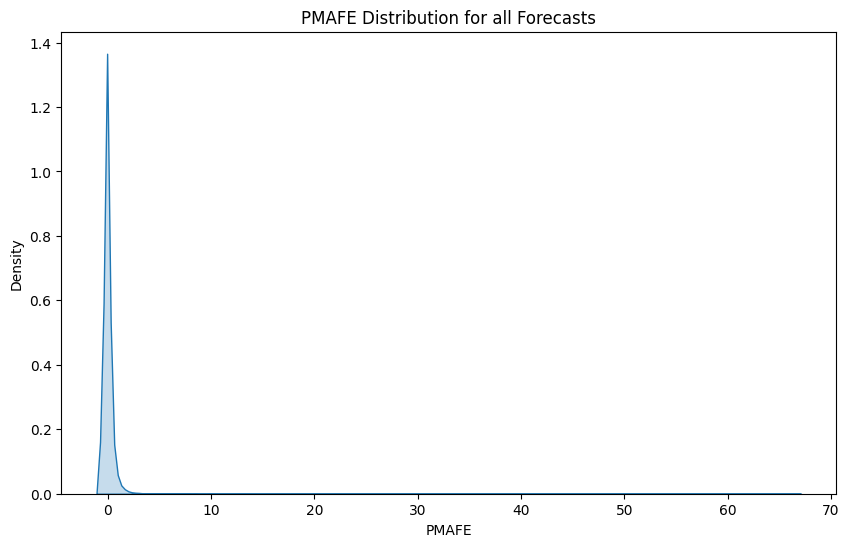

In [ ]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

# Feature Engineering

## Feature 1: Broker Size

In [ ]:
def top_brokerage(df):
    """
    Function to add a dummy for each analyst that is employed by a firm in the top 50 brokerages in year t
    (Top 50: > 5.000 analysts)
    Set to 1 if analyst i is employed by a firm in the top 50 during year t (announce year), and set to 0 otherwise
    broker = df["estimator"]
    analyst = df["analyst"]
    broker_size = Count of analysts per brokerage in year t
    year = df["announce_date"].df.year 
    Output: this function adds a new column to the dataframe called "top_brokerage" with the dummy variable
    """
    # setup
    df["top_brokerage"] = 0
    df["broker_size"] = 0
    df["announce_date"] = pd.to_datetime(df["announce_date"])
    df["announce_year"] = df["announce_date"].dt.year
    
    # count of analysts per brokerage in year t
    df["broker_size"] = df.groupby(["estimator", "announce_year"])["analyst"].transform("count")
    
    # if count of analysts per brokerage in year t is greater than 5000, set top_brokerage to 1 otherwise 0
    df.loc[df["broker_size"] > 5000, "top_brokerage"] = 1
    
    
    return df

In [ ]:
df_forecasts = top_brokerage(df_forecasts)
df_forecasts.head()

## Feature 2:

# Collapse df

in the final df, one row should correspond to one analyst i's mean forecast of firm j in fiscal year t with accuracy measure pmafe

columns:
 - ibes_ticker_pk
 - company_name
 - gvkey
 - fiscal_period_ending
 - analyst
 - estimator
 - estimated_eps
 - mean_forecast_horizon
 - actual_eps
 - announce_date_actual
 - pmafe
 - afe_analyst_i_mean
 - afe_firm_j_mean
 - feature x
 - ...

In [34]:
df_forecasts.head()

ibes_ticker_pk official_ticker    company_name  estimator  analyst  \
0           0000            TLMR  TALMER BANCORP        149   119962   
1           0000            TLMR  TALMER BANCORP        228    80474   
2           0000            TLMR  TALMER BANCORP        952    50789   
3           0000            TLMR  TALMER BANCORP        873    79092   
4           0000            TLMR  TALMER BANCORP       1267    71182   

   estimated_eps fiscal_period_ending revision_date announce_date  actual_eps  \
0           0.73           2014-12-31    2014-03-11    2014-03-09        1.21   
1           0.83           2014-12-31    2014-03-11    2014-03-10        1.21   
2           0.66           2014-12-31    2014-03-11    2014-03-10        1.21   
3           0.80           2014-12-31    2014-03-11    2014-03-10        1.21   
4           0.86           2014-12-31    2014-04-07    2014-03-17        1.21   

  announce_date_actual forecast_horizon  mean_forecast_horizon_days  \
0           2015-01-30         297 days                         200   
1           2015-01-30         296 days                         214   
2           2015-01-30         296 days                         182   
3           2015-01-30         296 days                         187   
4           2015-01-30         289 days                         182   

   fpedats_year  anndats_year  afe_analyst_i  afe_analyst_ijt_mean  \
0          2014          2014           0.48              0.376000   
1          2014          2014           0.38              0.367143   
2          2014          2014           0.55              0.404000   
3          2014          2014           0.41              0.424286   
4          2014          2014           0.35              0.142500   

   afe_firm_jt_mean     pmafe  analyst_count  
0            0.3575  0.051748             28  
1            0.3575  0.026973             28  
2            0.3575  0.130070             28  
3            0.3575  0.186813             28  
4            0.3575 -0.601399             28

In [ ]:
# test
analyst_id = 113333
test = df_forecasts[(df_forecasts['official_ticker'] == "AAPL") & (df_forecasts['fiscal_period_ending'].dt.year == 2018) & (df_forecasts['analyst'] == analyst_id)]
test

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99534,AAPL,AAPL,APPLE,171,113333,2.900,2018-09-30,2018-01-29,2017-11-02,2.9775,2018-11-01,332 days,196,2018,2017,0.0775,0.06,0.130797,-0.541273,208
99597,AAPL,AAPL,APPLE,171,113333,2.935,2018-09-30,2018-04-30,2018-02-01,2.9775,2018-11-01,241 days,196,2018,2018,0.0425,0.06,0.130797,-0.541273,208
99664,AAPL,AAPL,APPLE,171,113333,2.885,2018-09-30,2018-07-30,2018-05-01,2.9775,2018-11-01,152 days,196,2018,2018,0.0925,0.06,0.130797,-0.541273,208
99706,AAPL,AAPL,APPLE,171,113333,2.950,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.06,0.130797,-0.541273,208


In [25]:
# Group by 'ibes_ticker_pk', 'analyst', 'fiscal_period_ending' and find the row with the minimum 'forecast_horizon'
min_forecast = test.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()

# Extract rows with the minimum forecast horizon
min_forecast_df = test.loc[min_forecast]

In [26]:
min_forecast_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99706,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.06,0.130797,-0.541273,208


In [27]:
def collapse_processed_df(df):
    """_summary_
    This function collapses/groups the input df into the final df so that one row should correspond to one analyst 
    i's forecast of firm j in fiscal year t with accuracy measure pmafe and other relevant features
    """
    min_forecast = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'])['forecast_horizon'].idxmin()
    min_forecast_df = df.loc[min_forecast]
    return min_forecast_df


In [28]:
collapsed_df = collapse_processed_df(df_forecasts)

In [ ]:
# all unique tickets analyst 1133333 has forecasted in 2018
analyst_113333 = collapsed_df[collapsed_df['analyst'] == 113333]
analyst_113333['ibes_ticker_pk'].unique()

array(['AAPL', 'AMCV', 'AMER', 'BBUY', 'CDLX', 'CDPD', 'CMCS', 'CRTO',
       'CSTR', 'DCHA', 'DCHA/2', 'DELL', 'DISH', 'DLIB', 'DMRC', 'DTSY',
       'FBK', 'GM12', 'GOOG', 'GOOG/1', 'GRUB', 'LCAP', 'LOGI', 'LYFT',
       'MVSN', 'NFLX', 'NWS', 'PPPP', 'RDFN', 'RNWK', 'SNE', 'SNIW',
       'TIVO', 'TWCA', 'TWEE', 'UEIC', 'VIA', 'VIAB', 'YELP', 'ZIL',
       'ZIL/1'], dtype=object)

In [ ]:
filtered_df = collapsed_df[(collapsed_df['analyst'] == analyst_id) & (collapsed_df['fiscal_period_ending'].dt.year == 2018) & ((collapsed_df['official_ticker'] == "NFLX") | (collapsed_df['official_ticker'] == "AAPL"))]
filtered_df

,ibes_ticker_pk,official_ticker,company_name,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,mean_forecast_horizon_days,fpedats_year,anndats_year,afe_analyst_i,afe_analyst_ijt_mean,afe_firm_jt_mean,pmafe,analyst_count
99706,AAPL,AAPL,APPLE,171,113333,2.95,2018-09-30,2018-09-04,2018-07-31,2.9775,2018-11-01,61 days,196,2018,2018,0.0275,0.060,0.130797,-0.541273,208
1377252,NFLX,NFLX,NETFLIX INC.,171,113333,2.62,2018-12-31,2019-01-15,2018-10-16,2.6800,2019-01-17,76 days,211,2018,2018,0.0600,0.285,0.150541,0.893166,205


# Export df

In [31]:
import os 
new_folder_path = '../data/processed' 

if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
file_path = os.path.join(new_folder_path, 'forecasts_pmafe_v2.parquet')
collapsed_df.to_parquet(file_path)

NameError: name 'collapsed_df' is not defined

In [60]:
crisp_cs_link = pd.read_csv('../data/raw/crisp-computsat-link.csv')
crisp_cs_link.to_parquet('../data/raw/crisp-computsat-link.parquet')

In [61]:
dataset2014 = pd.read_csv('../data/raw/dataset2014-2022-v3.csv')
dataset2014.to_parquet('../data/raw/dataset2014-2022-v3.parquet')

In [63]:
ibes_fc = pd.read_csv('../data/raw/ibes-forecasts.zip')
ibes_fc.to_parquet('../data/raw/ibes-forecasts.parquet')

In [64]:
old_data = pd.read_csv('../data/raw/1990-2014.zip')
old_data.to_parquet('../data/raw/1990-2014.parquet')

In [66]:
preproc = pd.read_pickle('../data/processed/forecasts_pmafe.pkl')
preproc.to_parquet('../data/processed/forecasts_pmafe.parquet')

In [67]:
link_crisp_ibes = pd.read_csv('../data/raw/link_table_crisp_ibes.csv')
link_crisp_ibes.to_parquet('../data/raw/link_table_crisp_ibes.parquet')